 # Парсинг данных и анализ. Кассовые сборы фильмов и бюджеты
 
Поработаем с данными о бюджетах фильмов и финансовых показателях с помощью сайта [The Numbers](https://www.the-numbers.com/movie/budgets/all).

In [1]:
!pip install fake_useragent

In [2]:
# импортируйте нужные библиотеки
import requests
from bs4 import BeautifulSoup
import pandas as pd
from fake_useragent import UserAgent
from tqdm import tqdm
from time import sleep
import matplotlib
%matplotlib inline 

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Парсинг данных

In [4]:
req = requests.get('https://www.the-numbers.com/movie/budgets/all')
print(req)

<Response [403]>


Мы впервые сталкиваемся с тем, что сервер не отдает нам данные по запросу. Но и из этой ситуации есть выход! Библиотека `fake_useragent`.

In [6]:
ua = UserAgent()
headers = {'User-Agent': ua.chrome}

In [7]:
req = requests.get('https://www.the-numbers.com/movie/budgets/all', headers=headers)
print(req)

<Response [200]>


In [8]:
soup = BeautifulSoup(req.text, 'html')

In [9]:
df = pd.read_html(str(soup.find('table')))[0]

In [10]:
df

,Unnamed: 0,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,1,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$533,200,000","$936,662,225","$2,064,615,817"
1,2,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,317,514,386"
2,3,"Jun 28, 2023",Indiana Jones and the Dial of Destiny,"$402,300,000","$174,480,468","$383,963,057"
3,4,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,748,242,781"
4,5,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802"
...,...,...,...,...,...,...
95,96,"Nov 22, 2023",Wish,"$200,000,000","$63,973,821","$240,274,313"
96,97,"Feb 28, 2020",Onward,"$200,000,000","$61,555,145","$133,357,601"
97,98,"Nov 22, 2023",Napoleon,"$200,000,000","$61,524,375","$217,917,156"
98,99,"Dec 16, 2020",Wonder Woman 1984,"$200,000,000","$46,801,036","$166,360,232"


Спарсим все данные по ссылке выше.

In [11]:
main = pd.DataFrame()

for i in tqdm(range(1, 66)):
    req = requests.get(f'https://www.the-numbers.com/movie/budgets/all/{i}01', headers=headers)
    soup = BeautifulSoup(req.text, 'html')
    table = soup.find('table')
    df1 = pd.read_html(str(table))[0]
    main = pd.concat([main, df1])
    sleep(1)

100%|██████████| 65/65 [03:07<00:00,  2.88s/it]


In [12]:
df = pd.concat([df, main])

In [13]:
df = df.set_index('Unnamed: 0')

In [14]:
df.shape

(6515, 5)

### EDA

* Сколько строк и столбцов содержит набор данных?
* Присутствуют ли значения NaN?
* Есть ли дублирующиеся строки?
* Какие типы данных столбцов?

In [15]:
# ваш код
df.isna().values.any()

False

In [16]:
df.duplicated().values.any()

False

In [17]:
?df.dropna

In [18]:
?df.drop_duplicates

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6515 entries, 1 to 6515
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Release Date       6515 non-null   object
 1   Movie              6515 non-null   object
 2   Production Budget  6515 non-null   object
 3   Domestic Gross     6515 non-null   object
 4   Worldwide Gross    6515 non-null   object
dtypes: object(5)
memory usage: 305.4+ KB


### Перевод данных

Переводим столбцы в нужные типы данных

In [20]:
my_cols = list(df.columns)
my_cols

['Release Date',
 'Movie',
 'Production Budget',
 'Domestic Gross',
 'Worldwide Gross']

In [22]:
df.head()

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
Unnamed: 0,,,,,
1,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$533,200,000","$936,662,225","$2,064,615,817"
2,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,317,514,386"
3,"Jun 28, 2023",Indiana Jones and the Dial of Destiny,"$402,300,000","$174,480,468","$383,963,057"
4,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,748,242,781"
5,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802"


In [23]:
cols = ['Production Budget', 'Domestic Gross', 'Worldwide Gross']

for col in cols:
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].str.replace(',', '')
    df[col] = pd.to_numeric(df[col])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6515 entries, 1 to 6515
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Release Date       6515 non-null   object
 1   Movie              6515 non-null   object
 2   Production Budget  6515 non-null   int64 
 3   Domestic Gross     6515 non-null   int64 
 4   Worldwide Gross    6515 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 305.4+ KB


### Описательная статистика

* Какой средний бюджет фильмов в наборе данных?
* Какой средний мировой доход фильмов?
* Какие минимальные показатели мирового и локального дохода фильмов?
* Какие самый высокий бюджет и самый высокий мировой доход среди фильмов?
* Какой доход принесли фильмы с самым низким и самым высоким бюджетом?

In [34]:
# ваш код
df.describe().map('{:,.2f}'.format)

,Production Budget,Domestic Gross,Worldwide Gross
count,"6,515.00","6,515.00","6,515.00"
mean,"32,788,846.19","42,069,128.22","93,571,239.79"
std,"44,646,120.26","72,028,923.18","185,962,801.03"
min,86.00,0.00,0.00
25%,"5,000,000.00","1,070,084.00","3,724,867.00"
50%,"17,000,000.00","16,124,543.00","27,176,825.00"
75%,"40,000,000.00","51,749,047.00","97,388,766.50"
max,"533,200,000.00","936,662,225.00","2,923,706,026.00"


<Axes: >

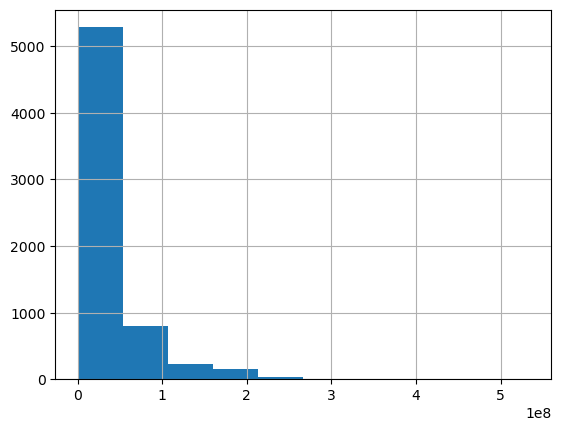

In [38]:
df['Production Budget'].hist(bins=10)

In [39]:
df[df['Production Budget'] == df['Production Budget'].min()]

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
Unnamed: 0,,,,,
6515,"Mar 2, 2021",Neeras,86,0,0


In [40]:
df[df['Worldwide Gross'] == df['Worldwide Gross'].max()]

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
Unnamed: 0,,,,,
33,"Dec 17, 2009",Avatar,237000000,785221649,2923706026


<Axes: >

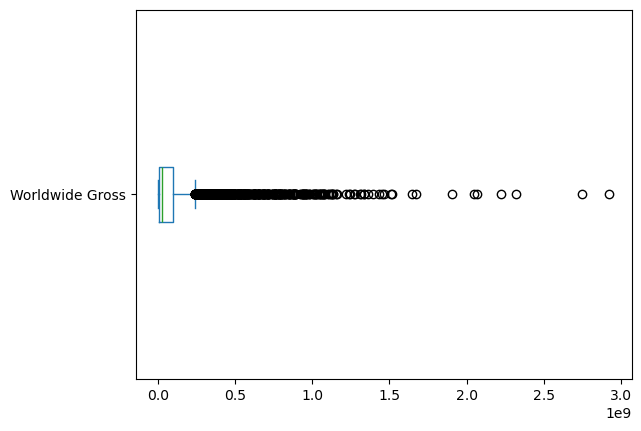

In [42]:
df['Worldwide Gross'].plot.box(vert=False)

In [ ]:
df['Worldwide Gross']

### Фильмы, потерявшие деньги

* Какой процент фильмов, в которых затраты на производство превысили мировой доход?

In [54]:
round(df[df['Production Budget'] > df['Worldwide Gross']].shape[0]/df.shape[0]*100 , 2)

37.54